In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [ ]:
# Load the data and transform it to a tensor by preparing the transform to be used before hand
# Prepare the data loader for the training set as well with batch size 64 and with shuffling

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 19293066.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 342644.01it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6110588.41it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5265124.85it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Instantiate the autoencoder
autoencoder = Autoencoder()


Explaining each layer for my own better understanding.

ENCODER:

1st Convolutional Layer
*   The first convolutional layer takes the input image, which has one channel (grayscale), and applies 16 filters to it. The choice of 16 output channels increases the depth of the representation.
*   The kernel size of 3x3 means that each filter looks at a 3x3 pixel neighborhood.
*   A stride of 2 reduces the spatial dimensions (width and height) by a factor of 2, effectively downscaling the image.
*   Padding of 1 ensures that the spatial dimensions remain roughly the same.

ReLU Activation: Introduce non-linearity in the model so it can capture non-linear relationships in the encoder

2nd Convolutional Layer
*   This is a similar convolutional layer but with 16 input channels (output from the previous layer) and 32 output channels, further increasing the depth of the representation.
*   Stride and padding settings are the same as in the previous layer.

Flatten Layer
*   Transformation: Converts the 2D feature maps into a 1D vector.
*   The Flatten layer is used to reshape the output from the convolutional layers into a 1D vector. This prepares the data for the fully connected layers in the decoder.

DECODER:

Unflatten Layer:
*   Transformation: Converts the 1D vector back into 2D feature maps.
*   This layer is used to reverse the flattening operation from the encoder. It reshapes the 1D vector into 2D feature maps with 32 channels and dimensions 7x7.

1st Transpose Convolution Layer
*   This is a transposed convolutional layer, also known as a deconvolutional layer. It takes the 32-channel 7x7 feature maps and upscales them by a factor of 2.
*   Padding ensures that spatial dimensions remain similar to the previous layer.
*   Output padding is used to ensure proper alignment of pixel values during the upscaling.

ReLU Activation: Introduce non-linearity in the model so it can capture non-linear relationships in the decoder

2nd Transpose Convolution Layer
*   This transposed convolutional layer further upscales the 16-channel feature maps to reconstruct a single-channel image (grayscale).
*   Sigmoid activation is used to squash the output values between 0 and 1, making them suitable for image pixel values.

In summary, the encoder part of the autoencoder reduces the dimensionality of the input image through a series of convolutional layers and ReLU activations. The decoder part reconstructs the original image from the lower-dimensional representation using transposed convolutional layers and ReLU activations. The Flatten and Unflatten layers are used to reshape the data between the encoder and decoder. This architecture is designed to learn a compact representation of the input data while maintaining the ability to reconstruct the original image.











In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer.zero_grad()
        encoded, outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

print("Finished Training")


Epoch 1/10, Loss: 0.01781518831908671
Epoch 2/10, Loss: 0.0025240643264433896
Epoch 3/10, Loss: 0.0016171941759565206
Epoch 4/10, Loss: 0.0011472184807861418
Epoch 5/10, Loss: 0.000927192148447696
Epoch 6/10, Loss: 0.0007641550099754186
Epoch 7/10, Loss: 0.0006705892255166367
Epoch 8/10, Loss: 0.0006125888397255893
Epoch 9/10, Loss: 0.0005630650174697794
Epoch 10/10, Loss: 0.0005253226412070502
Finished Training


After defining the autoencoder by defining the encoder and the decoder we define the training process and its parameters.

*   We use Mean Squared Error (MSE) loss as the reconstruction loss. It measures the pixel-wise difference between the original images and the reconstructed images.
*   Adam optimizer is used to optimize the autoencoder's parameters with a learning rate of 0.001.
*   The model is trained for 10 epochs. You can adjust the number of epochs as needed.
*   For each epoch, we loop through the training data, calculate the loss, perform backpropagation, and update the weights.

Inside the loop what happens is:
1.   Initialize the running loss for each epoch
2.   Get a batch of training images but ignore the labels
3.   Zero the gradients in the optimizer for each batch
4.  Get the encoded data and the outputs from the autencoder i.e. the encoded and then decoded data
5.  Feed the outputs and the inputs into the loss criterion defined above (in this case MSE loss)
6.  Run back propagation
7.  Update the weights
8.  Accumulate the loss
9.  Display the running loss for each epoch to visualize the progress of the loss (and thus the accuracy) at each epoch





In [ ]:
lower_dim_representations = []
with torch.no_grad():
    for data in trainloader:
        inputs, _ = data
        encoded, _ = autoencoder(inputs)
        lower_dim_representations.extend(encoded.cpu().numpy())

lower_dim_representations = torch.tensor(lower_dim_representations)


<ipython-input-7-bdbe1a32bf34>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  lower_dim_representations = torch.tensor(lower_dim_representations)


In order to get the lower dimensional representations we go through the batches and use the encoder only (hence the _ in line 5) to get the reduced dimensionality of 7 by 7 images. This is then appended to the array and at the end it is transformed to a tensor to be used with t-SNE

*   We initialize an empty list to store the lower-dimensional representations of the images.
*   We disable gradient computation using torch.no_grad() to speed up inference since we're not training the model.
*   We iterate through the training data, pass each image through the encoder part of the autoencoder to obtain the lower-dimensional representation (encoded), and then extend the list with these representations.


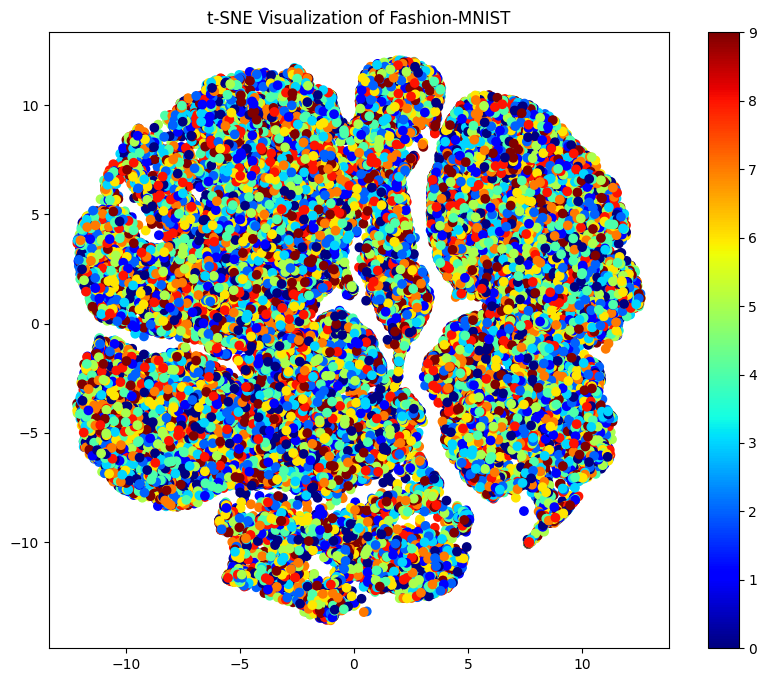

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
lower_dim_rep_2d = tsne.fit_transform(lower_dim_representations)

# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(lower_dim_rep_2d[:, 0], lower_dim_rep_2d[:, 1], c=trainset.targets, cmap='jet')
plt.colorbar()
plt.title("t-SNE Visualization of Fashion-MNIST")
plt.show()


The components of t-SNE is chosen 2 for visualization purposes and the perplexity is left at the default 30 as suggested to be a value between 5 and 50. Number of iterations is chosen 300 as it has to be at least 250 for a fast running time.
*  We apply t-SNE to the lower-dimensional representations obtained from the autoencoder.
*  Finally, we create a scatter plot to visualize the 2D representations, where each point corresponds to an image, and the color represents the class label in the Fashion-MNIST dataset.